In [2]:
archivosdf <- list.files(path = '../3.Datos generados/dataframes', pattern = "^df_grid_", full.names = TRUE)
archivosdf

[1] "../3.Datos generados/dataframes/df_grid_05.Rdata"
[2] "../3.Datos generados/dataframes/df_grid_1.Rdata" 
[3] "../3.Datos generados/dataframes/df_grid_15.Rdata"
[4] "../3.Datos generados/dataframes/df_grid_2.Rdata" 
[5] "../3.Datos generados/dataframes/df_grid_25.Rdata"
[6] "../3.Datos generados/dataframes/df_grid_3.Rdata" 
[7] "../3.Datos generados/dataframes/df_grid_4.Rdata" 
[8] "../3.Datos generados/dataframes/df_grid_5.Rdata"

In [3]:
ruta = '../3.Datos generados/dataframes/df_grid_1.Rdata'
ruta_grid = '../1.Upscaling/upscaling_fba/ fba_grid_1.Rdata'

In [4]:
ref.grid = get(load(ruta_grid))
df_grid <- get(load(ruta))
df_grid$orden <- seq(1,nrow(df_grid))

In [5]:
df_grid_filtered <- df_grid[!is.na(df_grid$MainStart) & is.na(df_grid$SencondStart),  ]
df_grid_filt_norm <- scale(df_grid_filtered[,8:10])

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1509950)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1509950)”


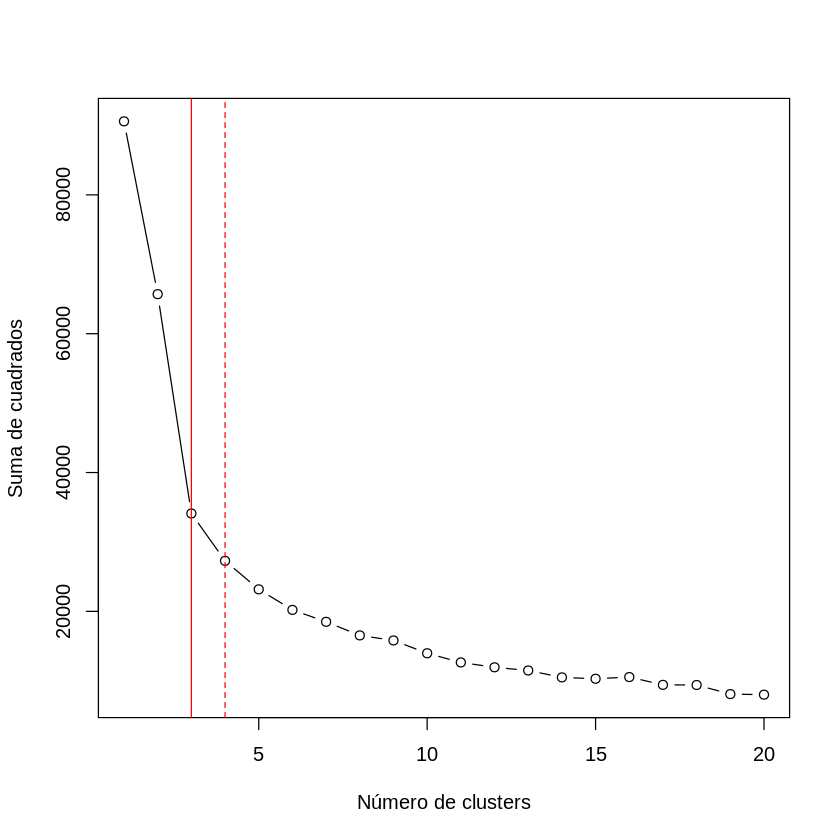

In [75]:
wss <- (nrow(df_grid_filt_norm)-1)*sum(apply(df_grid_filt_norm,2,var))
for (i in 2:20) wss[i] <- sum(kmeans(df_grid_filt_norm, centers=i)$withinss)
plot(1:20, wss, type="b", xlab="Número de clusters", ylab="Suma de cuadrados")
abline(v = 3, col = 'red')
abline(v = 4, lty = 2:3, col = 'red1')


In [10]:
png(filename = "num_clustersOptimos.png", width = 800, height = 600)
plot(1:20, wss, type="b", xlab="Número de clusters", ylab="Suma de cuadrados")
abline(v = 3, col = 'red')
abline(v = 4, lty = 2:3, col = 'red1')
dev.off()

png 
  2

3 es el valor óptimo de clusteres. Además incluiremos un cuarto para las bimodales

Visualizamos un árbol

In [6]:
distance = dist(df_grid_filt_norm)
grid.hclust = hclust(distance)
plot(grid.hclust)

In [7]:
member = cutree(grid.hclust,3)
table(member)

ERROR: Error in nrow(tree$merge): object 'grid.hclust' not found


Clusterizamos con k-means

In [8]:
kc <- kmeans(df_grid_filt_norm,3)
member2 <- kc$cluster
table(member2)

member2
   1    2    3 
4132 2104 2773 

In [9]:
df_grid_cl1 <- df_grid[rownames(df_grid) %in% names(member2[member2 ==1]), ]
df_grid_cl2 <- df_grid[rownames(df_grid) %in% names(member2[member2 ==2]), ]
df_grid_cl3 <- df_grid[rownames(df_grid) %in% names(member2[member2 ==3]), ]
#df_grid_cl4 <- df_grid[rownames(df_grid) %in% names(member2[member2 ==4]), ]


df_grid_cl1$cluster <- 1
df_grid_cl2$cluster <- 2
df_grid_cl3$cluster <- 3
#df_grid_cl4$cluster <- 4



#A las bimodales les asignamos un cluster propio
df_grid_bimodales <- df_grid[df_grid$FsOrNot != 0 & !is.na(df_grid$SencondStart),  ]
df_grid_bimodales$cluster <- 4
#Las que no tienen fire seasson las dejamos como NA
df_grid_sinFireSesasson <- df_grid[df_grid$FsOrNot == 0,  ]
df_grid_sinFireSesasson$cluster <- NA

#df_grid_NA<- df_grid[is.na(df_grid$FsOrNot),  ]
#df_grid_NA$cluster <- NA

nuevo_df_grid <- rbind(df_grid_cl1,df_grid_cl2, df_grid_cl3,df_grid_bimodales,df_grid_sinFireSesasson)
nuevo_df_grid<- nuevo_df_grid[order(nuevo_df_grid$orden),]
nuevo_df_grid$orden <- NULL

Visualizamos

In [10]:
library("visualizeR")

quantity2clim <- function(quantity, what, ref.grid, backperm = NULL) {
  if(!is.null(backperm)){quantity <- quantity[backperm]}
  mat <- matrix(quantity, nrow = 1)  
  ref.grid$Data <- mat2Dto3Darray(mat, x = ref.grid$xyCoords$x , y = ref.grid$xyCoords$y)
  attr(ref.grid$Data, "climatology:fun") <- what
  return(ref.grid)
}


Loading required package: transformeR




    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.1.3 (2021-08-04) is loaded


Get the latest stable version (2.1.5) using <devtools::install_github('SantanderMetGroup/transformeR')>

Please see 'citation("transformeR")' to cite this package.

Warning message:
“no DISPLAY variable so Tk is not available”
visualizeR version 1.6.1 (2021-03-11) is loaded


Get the latest stable version (1.6.3) using <devtools::install_github('SantanderMetGroup/visualizeR')>

Please see 'citation("visualizeR")' to cite this package.



In [11]:
nuevo_df_grid_order <- nuevo_df_grid[order(nuevo_df_grid$X),]

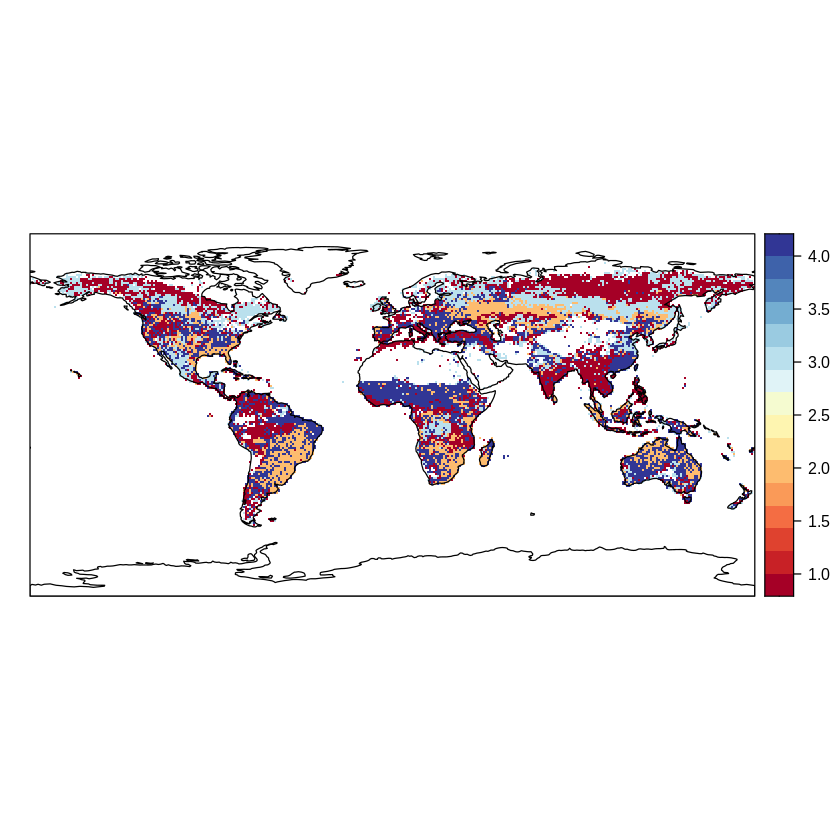

In [12]:
clim <- quantity2clim(quantity = nuevo_df_grid_order$cluster,what = 'Clusters',ref.grid = ref.grid )
plotClim <- spatialPlot(clim,backdrop.theme = 'coastline') #at = seq(0,1,0.1)
plotClim

In [13]:
plotname <- "clusters1.pdf"
pdf(plotname)
plotClim
dev.off()

png 
  2

In [106]:
clusters <- c(1:4)
num_pixeles <- c()
media_mainFireStart <- c()
desv_mainFireStart <- c()
media_mainFireEnd <- c()
desv_mainFireEnd <- c()
num_bimodal <- c()
media_fireSeassonLength <- c()
desv_fireSeassonLength <- c()
media_SeassonalConcentration <- c()
desv_SeassonalConcentration <- c()
media_SeassonalTiming <- c()
desv_SeassonalTiming <- c()
for (cluster in clusters){
    df_cluster <- nuevo_df_grid[!is.na(nuevo_df_grid$cluster)& nuevo_df_grid$cluster ==cluster,]
    df_bimodales <- df_cluster[!is.na(df_cluster$SencondStart), ] 
    
    num_pixeles <- c(num_pixeles, nrow(df_cluster))
    media_mainFireStart <- c(media_mainFireStart, mean(df_cluster$MainStart))
    desv_mainFireStart <- c(desv_mainFireStart, sd(df_cluster$MainStart))
    media_mainFireEnd <- c(media_mainFireEnd, mean(df_cluster$MainEnd))
    desv_mainFireEnd <- c(desv_mainFireEnd, sd(df_cluster$MainEnd))
    media_fireSeassonLength <- c(media_fireSeassonLength, mean(df_cluster$Length))
    desv_fireSeassonLength <- c(desv_fireSeassonLength, sd(df_cluster$Length))
    media_SeassonalConcentration <- c(media_SeassonalConcentration, mean(df_cluster$C))
    desv_SeassonalConcentration <- c(desv_SeassonalConcentration, sd(df_cluster$C))
    media_SeassonalTiming <- c(media_SeassonalTiming, mean(df_cluster$P))
    desv_SeassonalTiming <- c(desv_SeassonalTiming, sd(df_cluster$P))
    num_bimodal <- c(num_bimodal, nrow(df_bimodales))
}
df_comparativaClusters <- data.frame(clusters, num_pixeles, num_bimodal, media_mainFireStart, desv_mainFireStart, 
                                  media_mainFireEnd, desv_mainFireEnd,media_fireSeassonLength, desv_fireSeassonLength,
                                  media_SeassonalConcentration, desv_SeassonalConcentration, media_SeassonalTiming,desv_SeassonalTiming)
df_comparativaClusters

clusters,num_pixeles,num_bimodal,media_mainFireStart,desv_mainFireStart,media_mainFireEnd,desv_mainFireEnd,media_fireSeassonLength,desv_fireSeassonLength,media_SeassonalConcentration,desv_SeassonalConcentration,media_SeassonalTiming,desv_SeassonalTiming
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14892,0,4.770481,2.513512,5.854956,2.573879,2.084475,1.168203,0.9211557,0.07239292,0.990776420,0.3971803
2,10115,0,5.011172,2.262000,5.650618,2.053739,1.639446,1.005918,0.9218357,0.09196505,-0.823653655,0.5493217
3,5192,0,2.227080,1.354891,7.684707,1.825823,6.457627,2.138828,0.5881744,0.20192086,0.303446479,0.8406236
4,11309,11309,1.904501,1.404074,3.445751,1.819547,5.239986,2.023183,0.7113882,0.20999390,-0.006908851,0.9207508


In [108]:
Cluster <- c(1,NA,2,NA,3,NA,4,NA)
Píxeles <- c()
Bimodales <- c()
MainStart <- c()
MainEnd <- c()
Length <- c()
C <- c()
P <- c()
for (cluster in 1:4){
    df_cluster <- nuevo_df_grid[!is.na(nuevo_df_grid$cluster) & nuevo_df_grid$cluster == cluster, ]
    df_bimodales <- df_cluster[!is.na(df_cluster$SencondStart), ] 
    
    Píxeles <- c(Píxeles, nrow(df_cluster), NA)
    
    Bimodales <- c(Bimodales, nrow(df_bimodales), NA)
    
    MainStart <- c(MainStart, mean(df_cluster$MainStart),sd(df_cluster$MainStart))

    MainEnd <- c(MainEnd, mean(df_cluster$MainEnd),sd(df_cluster$MainEnd))
    
    Length <- c(Length, mean(df_cluster$Length), sd(df_cluster$Length))

    C <- c(C, mean(df_cluster$C), sd(df_cluster$C))

    P <- c(P, mean(df_cluster$P), sd(df_cluster$P))
}
df_comparativaClusters <- data.frame(
  Cluster,
  Píxeles,
  Bimodales,
  MainStart,
  MainEnd,
  Length,
  C,
  P
)
df_comparativaClusters

Cluster,Píxeles,Bimodales,MainStart,MainEnd,Length,C,P
<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14892,0,4.770481,5.854956,2.084475,0.92115570,0.990776420
NA,NA,NA,2.513512,2.573879,1.168203,0.07239292,0.397180336
2,10115,0,5.011172,5.650618,1.639446,0.92183565,-0.823653655
NA,NA,NA,2.262000,2.053739,1.005918,0.09196505,0.549321694
3,5192,0,2.227080,7.684707,6.457627,0.58817442,0.303446479
NA,NA,NA,1.354891,1.825823,2.138828,0.20192086,0.840623557
4,11309,11309,1.904501,3.445751,5.239986,0.71138822,-0.006908851
NA,NA,NA,1.404074,1.819547,2.023183,0.20999390,0.920750807


In [222]:
library(xtable)
table <- xtable(df_comparativaClusters)
print(table, include.rownames = FALSE)

% latex table generated in R 3.6.3 by xtable 1.8-4 package
% Sun Sep 17 07:45:28 2023
\begin{table}[ht]
\centering
\begin{tabular}{rrrrrrrr}
  \hline
Cluster & Píxeles & Bimodales & MainStart & MainEnd & Length & C & P \\ 
  \hline
1.00 & 14892 &   0 & 4.77 & 5.85 & 2.08 & 0.92 & 0.99 \\ 
   &  &  & 2.51 & 2.57 & 1.17 & 0.07 & 0.40 \\ 
  2.00 & 10115 &   0 & 5.01 & 5.65 & 1.64 & 0.92 & -0.82 \\ 
   &  &  & 2.26 & 2.05 & 1.01 & 0.09 & 0.55 \\ 
  3.00 & 5192 &   0 & 2.23 & 7.68 & 6.46 & 0.59 & 0.30 \\ 
   &  &  & 1.35 & 1.83 & 2.14 & 0.20 & 0.84 \\ 
  4.00 & 11309 & 11309 & 1.90 & 3.45 & 5.24 & 0.71 & -0.01 \\ 
   &  &  & 1.40 & 1.82 & 2.02 & 0.21 & 0.92 \\ 
   \hline
\end{tabular}
\end{table}


##### Centroides

In [229]:
member2 <- kc$cluster
table(member2)

member2
    1     2     3 
14892 10115  5192 

In [237]:
kc$centers
centroides <- data.frame(kc$centers)
centroides_length <- centroides$Length
centroides_C <- centroides$C
centroides_P <- centroides$P

,Length,C,P
1,-0.2754469,0.3393264,0.74190764
2,-0.4788009,0.3433728,-1.11252407
3,1.7228480,-1.6422313,0.03942456


In [ ]:
df_cl[df_cl$Length == centroides_length[ncluster] & df_cl$C == centroides_C[ncluster] & df_cl$P ==centroides_P[ncluster]]

In [307]:
df_centroids <- data.frame()
for (ncluster in c(1:3)){
    df_cl <- nuevo_df_grid[nuevo_df_grid$cluster == ncluster, ]
    for (row in 1:nrow(df_cl)){
        df_cl$Length[row] <- abs(df_cl$Length[row] - centroides_length[ncluster])
        df_cl$C[row] <- abs(df_cl$C[row] - centroides_C[ncluster])
        df_cl$P[row] <- abs(df_cl$P[row] - centroides_P[ncluster])
    }
    
    df_cl_ordered <- df_cl[order(df_cl$Length,df_cl$C, df_cl$P),][4,]
    df_centroids <- rbind(df_centroids,df_cl_ordered)
}  



Se escogen otros pixeles en vez de los centroides para visualizar

In [322]:
df_comparativaClusters

Cluster,Píxeles,Bimodales,MainStart,MainEnd,Length,C,P
<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14892,0,4.770481,5.854956,2.084475,0.92115570,0.990776420
NA,NA,NA,2.513512,2.573879,1.168203,0.07239292,0.397180336
2,10115,0,5.011172,5.650618,1.639446,0.92183565,-0.823653655
NA,NA,NA,2.262000,2.053739,1.005918,0.09196505,0.549321694
3,5192,0,2.227080,7.684707,6.457627,0.58817442,0.303446479
NA,NA,NA,1.354891,1.825823,2.138828,0.20192086,0.840623557
4,11309,11309,1.904501,3.445751,5.239986,0.71138822,-0.006908851
NA,NA,NA,1.404074,1.819547,2.023183,0.20999390,0.920750807


In [371]:
df_cl1 = nuevo_df_grid[nuevo_df_grid$cluster == 1 & nuevo_df_grid$Length == 2 & nuevo_df_grid$C > 0.9 & nuevo_df_grid$P > 0.9, ][1:10,]

In [372]:
df_cl2 = nuevo_df_grid[nuevo_df_grid$cluster == 2 & nuevo_df_grid$Length == 2 & nuevo_df_grid$C > 0.9 & nuevo_df_grid$P < 0, ][1:20,]

In [373]:
df_cl3 = nuevo_df_grid[nuevo_df_grid$cluster == 3 & nuevo_df_grid$Length == 7 & nuevo_df_grid$C < 0.5 & nuevo_df_grid$P > 0.3, ][1:10,]

In [374]:
df_cl4 = nuevo_df_grid[nuevo_df_grid$cluster == 4 & nuevo_df_grid$Length == 7 & nuevo_df_grid$C < 0.5 & nuevo_df_grid$P > 0.3, ][1:10,]

In [375]:
df_centroidesProximos = list(df_cl1, df_cl2, df_cl3, df_cl4)
save(df_centroidesProximos, file = 'df_centroidesProximos.Rdata')

In [360]:
save(nuevo_df_grid, file = 'df_clusters.Rdata')

In [362]:
grid_ba <- get(load('../1.Upscaling/upscaling_ba/ba_grid_05.Rdata'))


In [364]:
sd <- grid2sp(grid_ba)

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO"):
“Discarded datum WGS_1984 in CRS definition,
 but +towgs84= values preserved”


In [370]:
max(nuevo_df_grid$cluster)

[1] 4